### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [2]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [3]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Using TensorFlow backend.


In [5]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [6]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [7]:
# 印出網路結構
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73856     
__________

In [8]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [9]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')




Train on 1712 samples, validate on 428 samples
Epoch 1/150





1712/1712 [==============================] - 8s 5ms/step - loss: 0.0069 - val_loss: 0.0022

Epoch 00001: val_loss improved from inf to 0.00215, saving model to best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 7s 4ms/step - loss: 0.0018 - val_loss: 0.0020

Epoch 00002: val_loss improved from 0.00215 to 0.00195, saving model to best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 9s 5ms/step - loss: 0.0014 - val_loss: 0.0020

Epoch 00003: val_loss improved from 0.00195 to 0.00195, saving model to best_weights.h5
Epoch 4/150
1712/1712 [==============================] - 7s 4ms/step - loss: 0.0013 - val_loss: 0.0018

Epoch 00004: val_loss improved from 0.00195 to 0.00184, saving model to best_weights.h5
Epoch 5/150
1712/1712 [==============================] - 7s 4ms/step - loss: 0.0011 - val_loss: 0.0018

Epoch 00005: val_loss did not improve from 0.00184
Epoch 6/150
1712/1712 [===

1712/1712 [==============================] - 7s 4ms/step - loss: 2.2333e-04 - val_loss: 7.8952e-04

Epoch 00037: val_loss did not improve from 0.00077
Epoch 38/150
1712/1712 [==============================] - 7s 4ms/step - loss: 2.2349e-04 - val_loss: 8.0016e-04

Epoch 00038: val_loss did not improve from 0.00077
Epoch 39/150
1712/1712 [==============================] - 7s 4ms/step - loss: 2.2201e-04 - val_loss: 7.8602e-04

Epoch 00039: val_loss did not improve from 0.00077
Epoch 40/150
1712/1712 [==============================] - 7s 4ms/step - loss: 2.0803e-04 - val_loss: 7.8614e-04

Epoch 00040: val_loss did not improve from 0.00077
Epoch 41/150
1712/1712 [==============================] - 7s 4ms/step - loss: 2.1033e-04 - val_loss: 7.6500e-04

Epoch 00041: val_loss improved from 0.00077 to 0.00076, saving model to best_weights.h5
Epoch 42/150
1712/1712 [==============================] - 7s 4ms/step - loss: 2.0825e-04 - val_loss: 8.0596e-04

Epoch 00042: val_loss did not improve from 

1712/1712 [==============================] - 6s 3ms/step - loss: 1.3297e-04 - val_loss: 7.6140e-04

Epoch 00086: val_loss did not improve from 0.00073
Epoch 87/150
1712/1712 [==============================] - 6s 4ms/step - loss: 1.3356e-04 - val_loss: 7.3466e-04

Epoch 00087: val_loss did not improve from 0.00073
Epoch 88/150
1712/1712 [==============================] - 6s 4ms/step - loss: 1.2846e-04 - val_loss: 7.3403e-04

Epoch 00088: val_loss did not improve from 0.00073
Epoch 89/150
1712/1712 [==============================] - 6s 4ms/step - loss: 1.2810e-04 - val_loss: 7.9040e-04

Epoch 00089: val_loss did not improve from 0.00073
Epoch 90/150
1712/1712 [==============================] - 7s 4ms/step - loss: 1.2817e-04 - val_loss: 7.5366e-04

Epoch 00090: val_loss did not improve from 0.00073
Epoch 91/150
1712/1712 [==============================] - 7s 4ms/step - loss: 1.2434e-04 - val_loss: 7.6391e-04

Epoch 00091: val_loss did not improve from 0.00073
Epoch 92/150
1712/1712 [=====


Epoch 00135: val_loss did not improve from 0.00073
Epoch 136/150
1712/1712 [==============================] - 7s 4ms/step - loss: 9.3659e-05 - val_loss: 7.4838e-04

Epoch 00136: val_loss did not improve from 0.00073
Epoch 137/150
1712/1712 [==============================] - 7s 4ms/step - loss: 9.5060e-05 - val_loss: 7.4971e-04

Epoch 00137: val_loss did not improve from 0.00073
Epoch 138/150
1712/1712 [==============================] - 7s 4ms/step - loss: 9.2041e-05 - val_loss: 7.8890e-04

Epoch 00138: val_loss did not improve from 0.00073
Epoch 139/150
1712/1712 [==============================] - 7s 4ms/step - loss: 9.2411e-05 - val_loss: 7.4408e-04

Epoch 00139: val_loss did not improve from 0.00073
Epoch 140/150
1712/1712 [==============================] - 7s 4ms/step - loss: 9.6469e-05 - val_loss: 7.9070e-04

Epoch 00140: val_loss did not improve from 0.00073
Epoch 141/150
1712/1712 [==============================] - 7s 4ms/step - loss: 9.4087e-05 - val_loss: 7.8976e-04

Epoch 001

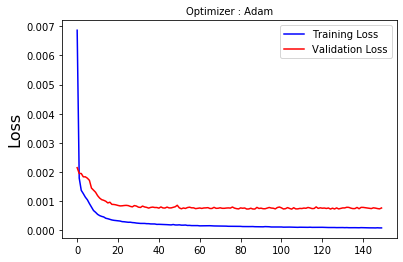

In [10]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [11]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [12]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

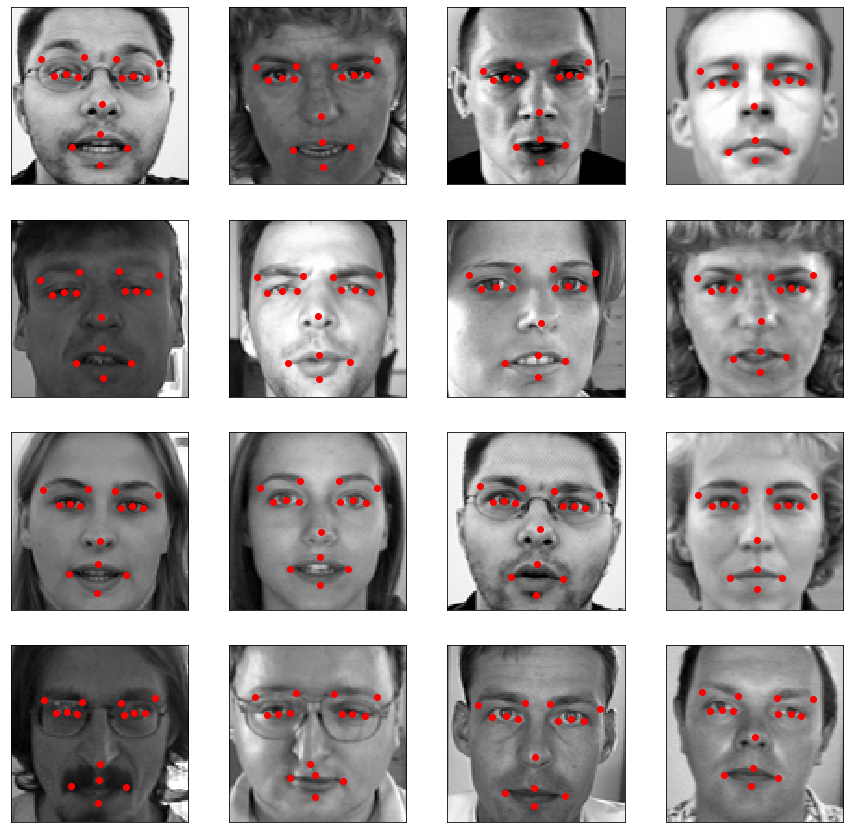

In [13]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [14]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
# 實現圖片以及關機點 label 做左右翻轉的函數
def augment_data(img, points):
    rows, cols = img.shape
    new_img = np.copy(img)
    
    # 翻轉圖片
    for i in range(96):
        for j in range(48):
            temp = img[i][j]
            new_img[i][j] = img[i][cols-j-1]
            new_img[i][cols-j-1] = temp
            
    # 翻轉關鍵點 label
    new_points = np.copy(points)
    for i in range(0,30,2):
        new_points[i] = -points[i]
    
    # 調整對稱的 label
    new_points_temp = np.copy(new_points)
    new_points[0:2] = new_points_temp[2:4]
    new_points[2:4] = new_points_temp[0:2]
    new_points[4:6] = new_points_temp[8:10]
    new_points[6:8] = new_points_temp[10:12]
    new_points[8:10] = new_points_temp[4:6]
    new_points[10:12] = new_points_temp[6:8]
    new_points[12:14] = new_points_temp[16:18]
    new_points[14:16] = new_points_temp[18:20]
    new_points[16:18] = new_points_temp[12:14]
    new_points[18:20] = new_points_temp[14:16]
    new_points[22:24] = new_points_temp[24:26]
    new_points[24:26] = new_points_temp[22:24]
        
    return new_img, new_points

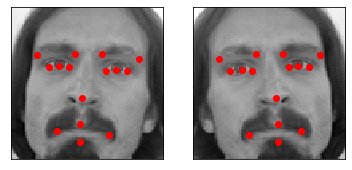

In [16]:
flip_img, flip_points = augment_data(imgs_train[0], points_train[0])

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_keypoints(imgs_train[0], points_train[0]) # 原來的圖片
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_keypoints(flip_img, flip_points) # 翻轉後的圖片

In [17]:
# 創建 list
aug_imgs_train = []
aug_points_train = []

# 對所有原始資料做 augmentation
for i in range(imgs_train.shape[0]):
    # 做左右翻轉
    aug_img, aug_point = augment_data(imgs_train[i], points_train[i])
    
    # append 原始資料
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i]) 
    
    # append 做過 augmentation 後的資料
    aug_imgs_train.append(aug_img)
    aug_points_train.append(aug_point) 

# convert to numpy
aug_imgs_train = np.array(aug_imgs_train)   
aug_points_train = np.copy(aug_points_train)

print(aug_imgs_train.shape)
print(aug_points_train.shape)

(4280, 96, 96)
(4280, 30)


In [18]:
# model checkpoint 
checkpoint_aug = ModelCheckpoint('best_weights_augment.h5', verbose=1, save_best_only=True)
# training the model
hist_model_aug = model_with_augment.fit(aug_imgs_train.reshape(aug_imgs_train.shape[0], 96, 96, 1), aug_points_train, 
                           validation_split=0.2, batch_size=64, callbacks=[checkpoint_aug, hist],
                           shuffle=True, epochs=150, verbose=1)

Train on 3424 samples, validate on 856 samples
Epoch 1/150
3424/3424 [==============================] - 15s 5ms/step - loss: 0.0038 - val_loss: 0.0018

Epoch 00001: val_loss improved from inf to 0.00180, saving model to best_weights_augment.h5
Epoch 2/150
3424/3424 [==============================] - 14s 4ms/step - loss: 0.0013 - val_loss: 0.0019

Epoch 00002: val_loss did not improve from 0.00180
Epoch 3/150
3424/3424 [==============================] - 13s 4ms/step - loss: 0.0011 - val_loss: 0.0018

Epoch 00003: val_loss improved from 0.00180 to 0.00177, saving model to best_weights_augment.h5
Epoch 4/150
3424/3424 [==============================] - 12s 4ms/step - loss: 8.3417e-04 - val_loss: 0.0014

Epoch 00004: val_loss improved from 0.00177 to 0.00142, saving model to best_weights_augment.h5
Epoch 5/150
3424/3424 [==============================] - 13s 4ms/step - loss: 6.2055e-04 - val_loss: 0.0012

Epoch 00005: val_loss improved from 0.00142 to 0.00121, saving model to best_weights_

3424/3424 [==============================] - 12s 4ms/step - loss: 1.4108e-04 - val_loss: 6.1592e-04

Epoch 00046: val_loss did not improve from 0.00060
Epoch 47/150
3424/3424 [==============================] - 12s 4ms/step - loss: 1.4109e-04 - val_loss: 6.2708e-04

Epoch 00047: val_loss did not improve from 0.00060
Epoch 48/150
3424/3424 [==============================] - 12s 4ms/step - loss: 1.3871e-04 - val_loss: 6.4258e-04

Epoch 00048: val_loss did not improve from 0.00060
Epoch 49/150
3424/3424 [==============================] - 12s 3ms/step - loss: 1.3742e-04 - val_loss: 6.3175e-04

Epoch 00049: val_loss did not improve from 0.00060
Epoch 50/150
3424/3424 [==============================] - 12s 4ms/step - loss: 1.3235e-04 - val_loss: 5.9185e-04

Epoch 00050: val_loss improved from 0.00060 to 0.00059, saving model to best_weights_augment.h5
Epoch 51/150
3424/3424 [==============================] - 13s 4ms/step - loss: 1.3662e-04 - val_loss: 6.1208e-04

Epoch 00051: val_loss did not

3424/3424 [==============================] - 12s 3ms/step - loss: 8.8447e-05 - val_loss: 6.2083e-04

Epoch 00095: val_loss did not improve from 0.00059
Epoch 96/150
3424/3424 [==============================] - 12s 3ms/step - loss: 8.8582e-05 - val_loss: 6.3509e-04

Epoch 00096: val_loss did not improve from 0.00059
Epoch 97/150
3424/3424 [==============================] - 12s 3ms/step - loss: 9.0613e-05 - val_loss: 6.0808e-04

Epoch 00097: val_loss did not improve from 0.00059
Epoch 98/150
3424/3424 [==============================] - 12s 3ms/step - loss: 8.8901e-05 - val_loss: 6.0679e-04

Epoch 00098: val_loss did not improve from 0.00059
Epoch 99/150
3424/3424 [==============================] - 12s 3ms/step - loss: 8.9255e-05 - val_loss: 6.1550e-04

Epoch 00099: val_loss did not improve from 0.00059
Epoch 100/150
3424/3424 [==============================] - 12s 3ms/step - loss: 8.9143e-05 - val_loss: 6.0899e-04

Epoch 00100: val_loss did not improve from 0.00059
Epoch 101/150
3424/342

3424/3424 [==============================] - 12s 3ms/step - loss: 7.7473e-05 - val_loss: 6.3210e-04

Epoch 00144: val_loss did not improve from 0.00059
Epoch 145/150
3424/3424 [==============================] - 12s 3ms/step - loss: 7.4222e-05 - val_loss: 6.3223e-04

Epoch 00145: val_loss did not improve from 0.00059
Epoch 146/150
3424/3424 [==============================] - 12s 3ms/step - loss: 7.5227e-05 - val_loss: 6.2572e-04

Epoch 00146: val_loss did not improve from 0.00059
Epoch 147/150
3424/3424 [==============================] - 12s 3ms/step - loss: 7.6217e-05 - val_loss: 6.2364e-04

Epoch 00147: val_loss did not improve from 0.00059
Epoch 148/150
3424/3424 [==============================] - 12s 3ms/step - loss: 7.8008e-05 - val_loss: 6.3950e-04

Epoch 00148: val_loss did not improve from 0.00059
Epoch 149/150
3424/3424 [==============================] - 12s 3ms/step - loss: 7.4566e-05 - val_loss: 6.3694e-04

Epoch 00149: val_loss did not improve from 0.00059
Epoch 150/150
3424

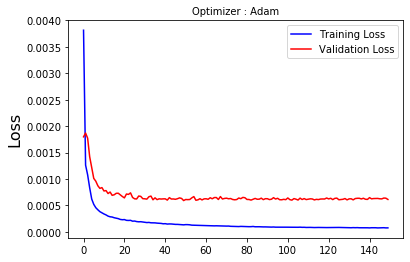

In [19]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model_aug.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model_aug.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')